In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os

In [2]:
dataset_path = './dataset'

### Covid xray dataset

In [4]:
samples = 25

Helper function to plot the images in a grid

In [8]:
def ceildiv(a, b):
    return -(-a // b)
def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

In [10]:
dataset_path

'./dataset'

In [11]:
normal_images = list(paths.list_images(f"{dataset_path}/normal"))
covid_images = list(paths.list_images(f"{dataset_path}/covid"))

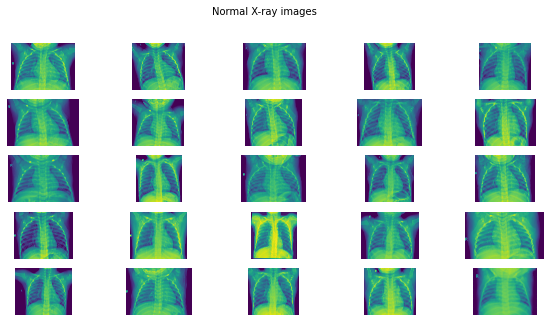

In [12]:
plots_from_files(normal_images, rows=5, maintitle="Normal X-ray images")

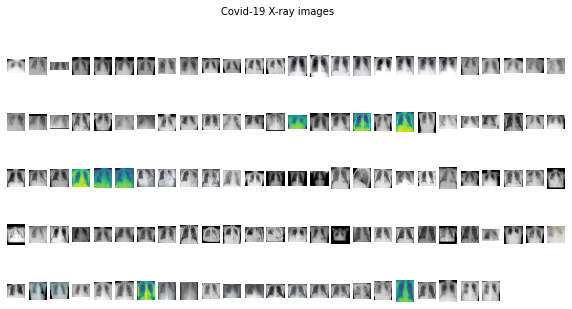

In [13]:
plots_from_files(covid_images, rows=5, maintitle="Covid-19 X-ray images")

## Data preprocessing

In [19]:
INIT_LR = 1e-3
EPOCHS = 15
BS = 25

In [15]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    data.append(image)
    labels.append(label)
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] loading images...


In [16]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# split train and test data
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)
# data augmentation 
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

## Model

In [17]:
# load the VGG16 model with imagenet weights 
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 5s 0us/step


### Training

In [20]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

print("[INFO] training head...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...


C:\Users\inba2\AppData\Local\Temp/ipykernel_17100/3420595593.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(


Epoch 1/15
4/4 [==============================] - 9s 2s/step - loss: 0.2884 - accuracy: 0.8542 - val_loss: 0.2116 - val_accuracy: 0.9032
Epoch 2/15
4/4 [==============================] - 9s 2s/step - loss: 0.2545 - accuracy: 0.9167 - val_loss: 0.2008 - val_accuracy: 0.9032
Epoch 3/15
4/4 [==============================] - 10s 3s/step - loss: 0.2574 - accuracy: 0.8958 - val_loss: 0.1930 - val_accuracy: 0.9355
Epoch 4/15
4/4 [==============================] - 11s 3s/step - loss: 0.2643 - accuracy: 0.9300 - val_loss: 0.1847 - val_accuracy: 0.9355
Epoch 5/15
4/4 [==============================] - 11s 3s/step - loss: 0.2528 - accuracy: 0.9271 - val_loss: 0.1777 - val_accuracy: 0.9355
Epoch 6/15
4/4 [==============================] - 12s 3s/step - loss: 0.2122 - accuracy: 0.9400 - val_loss: 0.1709 - val_accuracy: 0.9355
Epoch 7/15
4/4 [==============================] - 12s 3s/step - loss: 0.2038 - accuracy: 0.9271 - val_loss: 0.1643 - val_accuracy: 0.9355
Epoch 8/15
4/4 [====================

### Plot trining metrics

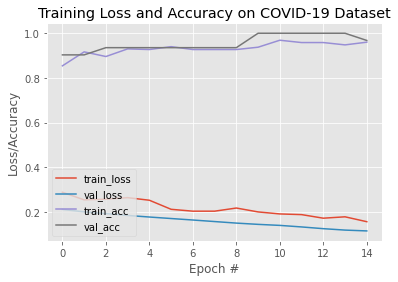

In [21]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

### Evaluation

In [22]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] evaluating network...
2/2 [==============================] - 2s 421ms/step
              precision    recall  f1-score   support

       covid       0.96      1.00      0.98        26
      normal       1.00      0.80      0.89         5

    accuracy                           0.97        31
   macro avg       0.98      0.90      0.94        31
weighted avg       0.97      0.97      0.97        31



Now save the model

In [25]:
# Save the entire model to a HDF5 file.
model.save('covid_model.h5') 

Test loaded model

In [27]:
from tensorflow.keras.models import load_model
# Recreate the exact same model
new_model = load_model('covid_model.h5')
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [28]:

print("[INFO] evaluating network...")
predIdxs = new_model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] evaluating network...
2/2 [==============================] - 2s 419ms/step
              precision    recall  f1-score   support

       covid       0.96      1.00      0.98        26
      normal       1.00      0.80      0.89         5

    accuracy                           0.97        31
   macro avg       0.98      0.90      0.94        31
weighted avg       0.97      0.97      0.97        31



Test on covid image:

1/1 [==============================] - 0s 89ms/step
[[1.0000000e+00 4.2161066e-10]]
[0]


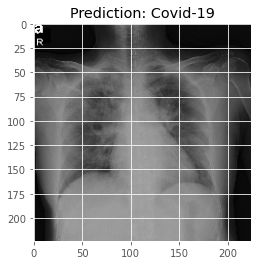

In [31]:
import numpy as np
from tensorflow.keras.preprocessing import image
img_width, img_height = 224, 224
img = image.load_img(r'dataset\covid\1-s2.0-S0929664620300449-gr2_lrg-a.jpg', target_size = (img_width, img_height))
x = image.img_to_array(img)
img = np.expand_dims(x, axis = 0)
# label with corresponding largest predicted probability
pred = new_model.predict(img)
print(pred)
print(np.argmax(pred, axis=1))
if np.argmax(pred, axis=1)[0] == 1:
    plt.title('Prediction: Non_Covid-19')
else:
    plt.title('Prediction: Covid-19')
plt.imshow(x/255.)
plt.savefig('plot_out.png')

Test on normal image:

1/1 [==============================] - 0s 92ms/step
[[0. 1.]]
1


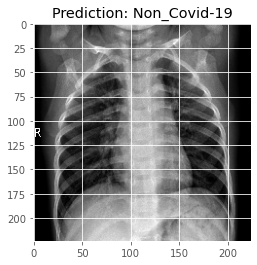

In [32]:
img_width, img_height = 224, 224
img = image.load_img(r'dataset\normal\NORMAL2-IM-0976-0001.jpeg', target_size = (img_width, img_height))
x = image.img_to_array(img)
img = np.expand_dims(x, axis = 0)
pred = new_model.predict(img)
print(pred)
# label with corresponding largest predicted probability
print(np.argmax(pred, axis=1)[0])
if np.argmax(pred, axis=1)[0] == 1:
    plt.title('Prediction: Non_Covid-19')
else:
    plt.title('Prediction: Covid-19')
plt.imshow(x/255.)